## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp_l1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
def build_mlp_l1_l2(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio,l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]
L1_L2_EXP = [[1e-2,1e-2],[1e-4,1e-2],[1e-2,1e-4],[1e-4,1e-4]]

In [7]:
results = {}

for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
#     print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp_l1_l2(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio[0],l2_ratio=regulizer_ratio[1])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [====

50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - accuracy: 0.0964 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 8s 150us/step - loss: 2.4626 - accuracy: 0.0991 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with Regulizer = 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________

Epoch 46/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.7943 - accuracy: 0.6199 - val_loss: 3.1028 - val_accuracy: 0.5055
Epoch 47/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.7597 - accuracy: 0.6199 - val_loss: 3.0247 - val_accuracy: 0.5233
Epoch 48/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.7197 - accuracy: 0.6214 - val_loss: 3.0783 - val_accuracy: 0.4981
Epoch 49/50
50000/50000 [==============================] - 8s 152us/step - loss: 2.6824 - accuracy: 0.6243 - val_loss: 2.9292 - val_accuracy: 0.5325
Epoch 50/50
50000/50000 [==============================] - 8s 153us/step - loss: 2.6403 - accuracy: 0.6244 - val_loss: 2.8824 - val_accuracy: 0.5323
Experiment with Regulizer = 0.000000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
___

50000/50000 [==============================] - 7s 148us/step - loss: 0.9576 - accuracy: 0.6636 - val_loss: 1.4214 - val_accuracy: 0.5177
Epoch 44/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9499 - accuracy: 0.6673 - val_loss: 1.3865 - val_accuracy: 0.5291
Epoch 45/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9304 - accuracy: 0.6738 - val_loss: 1.3878 - val_accuracy: 0.5275
Epoch 46/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9223 - accuracy: 0.6759 - val_loss: 1.3886 - val_accuracy: 0.5263
Epoch 47/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9095 - accuracy: 0.6812 - val_loss: 1.4176 - val_accuracy: 0.5246
Epoch 48/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9014 - accuracy: 0.6842 - val_loss: 1.3705 - val_accuracy: 0.5336
Epoch 49/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.8847 - accuracy: 0.6897 - val_loss:

Epoch 41/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9901 - accuracy: 0.6529 - val_loss: 1.3885 - val_accuracy: 0.5228
Epoch 42/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9731 - accuracy: 0.6588 - val_loss: 1.3713 - val_accuracy: 0.5234
Epoch 43/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9641 - accuracy: 0.6602 - val_loss: 1.3987 - val_accuracy: 0.5247
Epoch 44/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9511 - accuracy: 0.6655 - val_loss: 1.4671 - val_accuracy: 0.5061
Epoch 45/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9370 - accuracy: 0.6709 - val_loss: 1.3927 - val_accuracy: 0.5278
Epoch 46/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9240 - accuracy: 0.6731 - val_loss: 1.4251 - val_accuracy: 0.5175
Epoch 47/50
50000/50000 [==============================] - 8s 153us/step - loss: 0.9148 - accuracy: 0.6787

Epoch 39/50
50000/50000 [==============================] - 9s 176us/step - loss: 2.4616 - accuracy: 0.0980 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 8s 170us/step - loss: 2.4616 - accuracy: 0.0971 - val_loss: 2.4615 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4616 - accuracy: 0.0977 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4616 - accuracy: 0.0967 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 43/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4615 - accuracy: 0.0979 - val_loss: 2.4614 - val_accuracy: 0.1000
Epoch 44/50
50000/50000 [==============================] - 8s 169us/step - loss: 2.4615 - accuracy: 0.0972 - val_loss: 2.4613 - val_accuracy: 0.1000
Epoch 45/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4615 - accuracy: 0.0983

Epoch 37/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.8169 - accuracy: 0.4633 - val_loss: 1.8248 - val_accuracy: 0.4574
Epoch 38/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.8094 - accuracy: 0.4643 - val_loss: 1.8363 - val_accuracy: 0.4540
Epoch 39/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.8032 - accuracy: 0.4643 - val_loss: 1.8575 - val_accuracy: 0.4385
Epoch 40/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.7987 - accuracy: 0.4656 - val_loss: 1.8306 - val_accuracy: 0.4483
Epoch 41/50
50000/50000 [==============================] - 8s 169us/step - loss: 1.7929 - accuracy: 0.4665 - val_loss: 1.8075 - val_accuracy: 0.4597
Epoch 42/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.7872 - accuracy: 0.4686 - val_loss: 1.7987 - val_accuracy: 0.4671
Epoch 43/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.7829 - accuracy: 0.4695

Epoch 35/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 36/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - accuracy: 0.0974 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4627 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 9s 172us/step - loss: 2.4626 - accuracy: 0.0968 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - accuracy: 0.0979 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 9s 170us/step - loss: 2.4626 - accuracy: 0.0985 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 9s 171us/step - loss: 2.4626 - accuracy: 0.0972

Epoch 33/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.3793 - accuracy: 0.5866 - val_loss: 3.5537 - val_accuracy: 0.5153
Epoch 34/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.3263 - accuracy: 0.5895 - val_loss: 3.4849 - val_accuracy: 0.5292
Epoch 35/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.2707 - accuracy: 0.5946 - val_loss: 3.4700 - val_accuracy: 0.5185
Epoch 36/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.2199 - accuracy: 0.5983 - val_loss: 3.4458 - val_accuracy: 0.5124
Epoch 37/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.1713 - accuracy: 0.5987 - val_loss: 3.3534 - val_accuracy: 0.5199
Epoch 38/50
50000/50000 [==============================] - 8s 166us/step - loss: 3.1240 - accuracy: 0.5999 - val_loss: 3.2887 - val_accuracy: 0.5319
Epoch 39/50
50000/50000 [==============================] - 8s 165us/step - loss: 3.0720 - accuracy: 0.6022

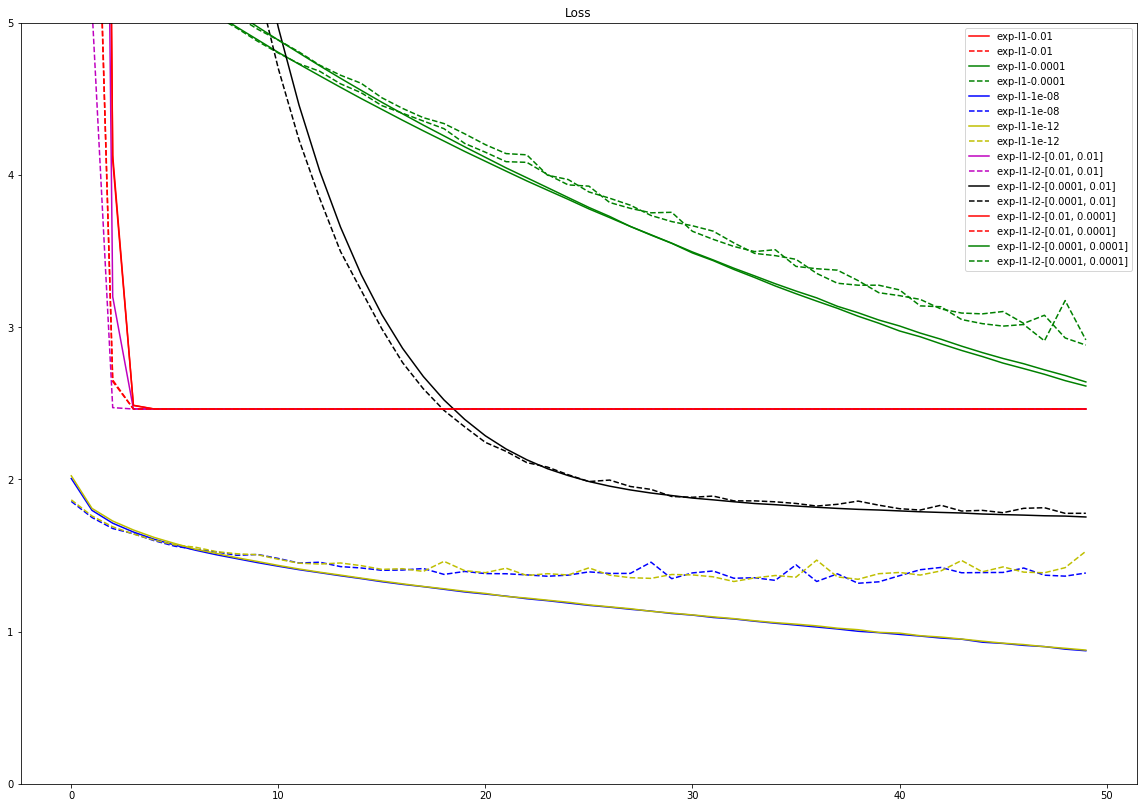

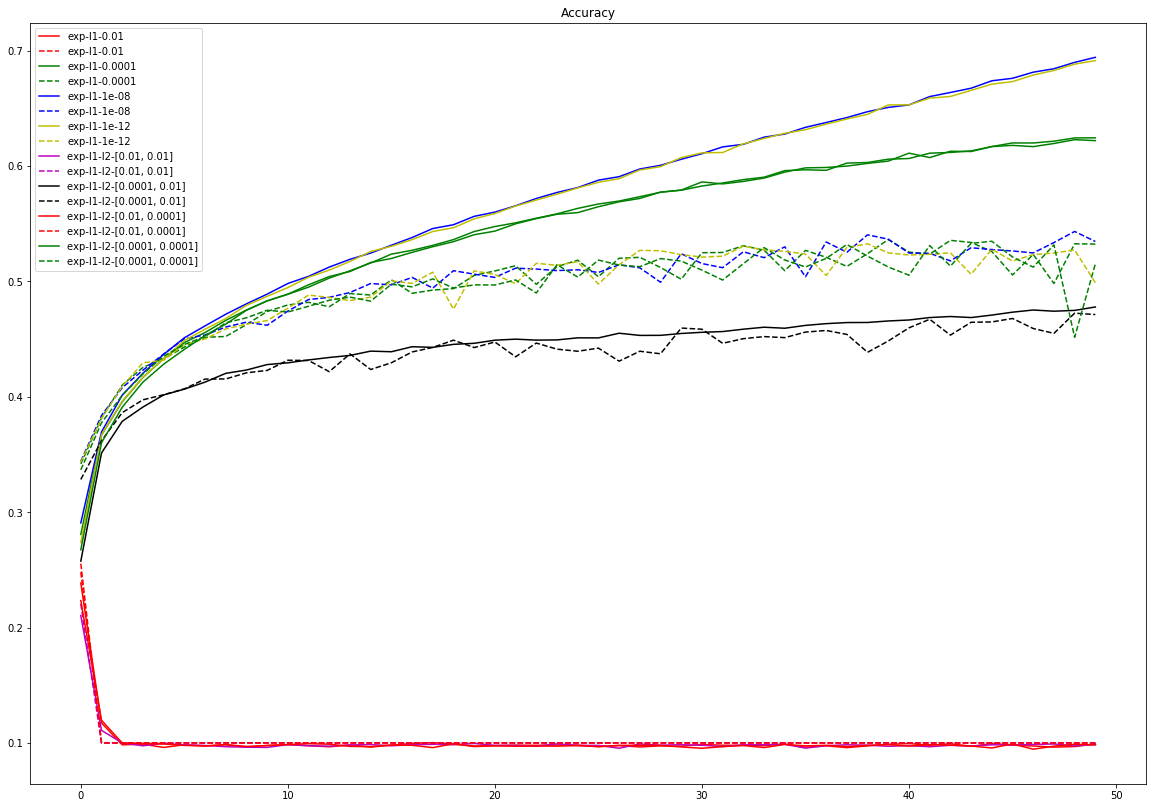

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(20,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()